# Semiclassical Szegedy Walk

In this notebook we will show an example of how to calculate the Semiclassical Szegedy Walk of a sample network using SQUWALS [[1]](https://advanced.onlinelibrary.wiley.com/doi/full/10.1002/qute.202400022), our simulator of Szegedy quantum walks.

**It is recommended to see first the SQUWALS tutorial notebook.**

**NetworkX is required for this notebook.**

## Table of Contents

- [Packages](#0)
- [1 - Graph Model](#1)
- [2 - Semiclassical Matrices](#2)
    - [2.1 - Semiclassical Matrices Simulation](#2-1)
    - [2.2 - Semiclassical Graphs Representation](#2-2)
- [3 - Semiclassical Walk Simulation](#3)
- [4 - Conclusions](#4)
- [5 - References](#5)

<a name='0'></a>
## Packages
First we import the libraries that we need, including our simulator.

In [1]:
import numpy as np
import networkx as nx
import squwals as sw
import matplotlib.pyplot as plt

<a name='1'></a>
## 1 - Graph Model

We need a transition matrix $G$ repressenting a classical walk. This matrix must be column stochastic, so that all the columns add up to 1. For this particular example, taken from [[2]](https://www.sciencedirect.com/science/article/pii/S0378437123005769), the matrix is doubly stochastic and symmetric, and corresponds to a graph with 7 nodes.

In [2]:
N = 7  # Size of the graph.

G = np.zeros([N,N])

G[0,3] = 0.3
G[1,3] = 0.4
G[2,3] = 0.1
G[3,4] = 0.2
G[4,5] = 0.3
G[4,6] = 0.5
G[5,6] = 0.5

G = G+G.T

G[0,0] = 0.7
G[1,1] = 0.6
G[2,2] = 0.9
G[3,3] = 0
G[4,4] = 0
G[5,5] = 0.2
G[6,6] = 0

G

array([[0.7, 0. , 0. , 0.3, 0. , 0. , 0. ],
       [0. , 0.6, 0. , 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0.9, 0.1, 0. , 0. , 0. ],
       [0.3, 0.4, 0.1, 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0.3, 0.5],
       [0. , 0. , 0. , 0. , 0.3, 0.2, 0.5],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. ]])

We can plot the graph corresponding to this matrix $G$ using NetworkX.

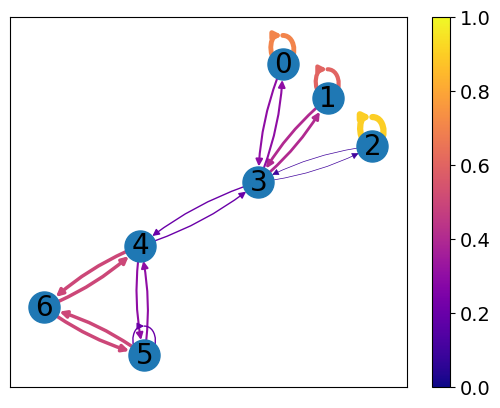

In [3]:
# Construct a directed graph with NetworkX and the transition matrix.
# In NetworkX the matrix of the graph is the transpose of the transition matrix.
graph = nx.from_numpy_array(G.T,create_using=nx.DiGraph)

# Function for obtaining the weights of the edges from a networkx graph.
def weights_gr(graph):
    G = nx.to_numpy_array(graph)
    edge_list = list(graph.edges())
    edge_weights = [G[edge] for edge in edge_list]
    edge_weights = np.array(edge_weights)
    return edge_weights

# Position dict for plotting the graph.
pos = {0:[0.31,0.7],
       1:[0.53,0.53],
       2:[0.75,0.29],
       3:[0.19,0.11],
       4:[-0.39,-0.21],
       5:[-0.37,-0.76],
       6:[-0.86,-0.52]}

# Code for plotting the graph.
cmap = plt.cm.plasma
graph_false = nx.from_numpy_array(G.T)
nodes = nx.draw_networkx_nodes(graph_false,pos=pos,node_color=[0 for a in graph.nodes()],cmap=cmap,vmin=0,vmax=1,node_size=0.1)
cbar = plt.colorbar(nodes)
cbar.ax.tick_params(labelsize=14)
nx.draw_networkx(graph, with_labels=True, pos=pos, width=weights_gr(graph)*5, edge_color=weights_gr(graph),edge_cmap=cmap,connectionstyle='arc3, rad = 0.1',edge_vmin=0,edge_vmax=1,node_size=500,font_size=20)
plt.show()

The weights of the edges are represented by the colormap. Moreover, to ease the visualization, the width of the edges are
proportional to their weights.

<a name='2'></a>
## 2 - Semiclassical Matrices

A semiclassical walk [[2]](https://www.sciencedirect.com/science/article/pii/S0378437123005769) is like a classical walk where the transition matrix encodes a quantum evolution. The semiclassical walks form a family of walks where each member is characterized by the number of quantum time steps performed per semiclassical step.

Moreover, we have two different classes of Szegedy semiclassical walks depending on which register is measured. Class $I$ corresponds to those where the first register is measured, whereas class $II$ corresponds to those where the second one is measured instead.

The transition matrices of the semiclassical walks are called semiclassical transition matrices, and are defined as follows:

\begin{equation}\label{G1}
	_1{G}{}^{(t_q)}_{ji} := \left|\left|_1{\left<j\right|U^{t_q}\left|\psi_i\right>}{}\right|\right|^2,
\end{equation}

\begin{equation}\label{G2}
	_2{G}{}^{(t_q)}_{ji} := \left|\left|_2{\left<j\right|U^{t_q}\left|\psi_i\right>}{}\right|\right|^2,
\end{equation}

where the left-subscript in the semiclassical matrices denotes the class of the walk, and the quantum time $t_q$ characterizes the particular semiclassical walk of the family.

<a name='2-1'></a>
### 2.1 - Semiclassical Matrices Simulation

In this example we are going to obtain the semiclassical matrices of class $I$ for our graph, using the single unitary operator:

$$U = SR.$$

We will use our function `semiclassical_szegedy_simulator` to obtain directly the semiclassical matrices, whithout needing to create the $\left|\psi_i\right>$ states and the unitary operator. This functions takes the classical transition matrix $G$ to create both these states and the unitary operator, and returns the semiclassical matrices.

This function has the following arguments:

-    transition_matrix: Column-stochastic transition matrix from which the states psi_i are obtained.
-    time_steps: Number of quantum time steps.
-    unitary: unitary operator model (optional). Default is 'single', so U = SR, constructing R from G.
-    batch_size: Number of states being vectorized at a batch. Default: batch_size = 1.
-    measure: An intenger indicating the register for measuring.
-    monitor: If True, the number of current simulated states is printed. Default to True.

The unitary parameter by default is `'single'`, so that it constructs the single Szegedy unitary $U=SR$. If we use `unitary = 'double'`, the operator $U = SRSR$ is used instead.

In [4]:
# Use the semiclassical simulator to obtain the semiclassical matrices of class I.
# We want to obtain the first 10 semiclassical walks.
# We measure the first register since we want the semiclassical walks of class I.
# We use unitary = 'single' to indicate that U = SR.
# We vectorize the calculations of the 7 states, so batch_size = 7.
semiclassical_matrices = sw.semiclassical_szegedy_simulator(transition_matrix=G,time_steps=10,unitary='single',batch_size=7,measure=1,monitor=False)

We can obtain the semiclassical matrices of both classes at the same time using `measure=12`. This results in a tuple where the first element are the semiclassical matrices of class $I$, and the second element the semiclassical matrices of class $II$.

Moreover, let's try a size of the batch smaller than the size of the graph, and monitor the calculations.

In [5]:
results = sw.semiclassical_szegedy_simulator(transition_matrix=G,time_steps=10,batch_size=3,measure=12,monitor=True)
semiclassical_matrices_class_I = results[0]  # Semiclassical matrices of class I.
semiclassical_matrices_class_II = results[1]  # Semiclassical matrices of class II.

Number of simulated nodes =  0
Epoch =  1 , Current nodes = 1 - 3
-------------------------
Number of simulated nodes =  3
Epoch =  2 , Current nodes = 4 - 6
-------------------------
Number of simulated nodes =  6
Epoch =  3 , Current nodes = 7 - 7
-------------------------
Number of simulated nodes =  7


The result of our semiclassical simulator is a 3D tensor, where the first dimension indicates the quantum time (including $t_q=0$), and the other two correspond to the matrices dimensions.

In this example, the matrices are $7 \times 7$, and there are 11 of them (counting $t_q=0$).

In [6]:
semiclassical_matrices.shape

(11, 7, 7)

For $t_q=0$ the semiclassical matrix is the identity, since there is no quantum evolution and we are measuring the first register.

In [7]:
semiclassical_matrices[0]

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

For $t_q=1$ the classical transition matrix is obtained.

In [8]:
semiclassical_matrices[1]

array([[0.7, 0. , 0. , 0.3, 0. , 0. , 0. ],
       [0. , 0.6, 0. , 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0.9, 0.1, 0. , 0. , 0. ],
       [0.3, 0.4, 0.1, 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0.3, 0.5],
       [0. , 0. , 0. , 0. , 0.3, 0.2, 0.5],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. ]])

For a larger value of the quantum time we obtain genuine transition matrices.

In [9]:
semiclassical_matrices[3]

array([[0.09856, 0.43776, 0.04896, 0.08832, 0.04032, 0.01728, 0.048  ],
       [0.42048, 0.03168, 0.0672 , 0.15936, 0.06144, 0.02304, 0.064  ],
       [0.08352, 0.1152 , 0.41472, 0.02304, 0.00576, 0.00576, 0.016  ],
       [0.21024, 0.14912, 0.43808, 0.59328, 0.02336, 0.30752, 0.072  ],
       [0.14112, 0.18432, 0.02592, 0.01568, 0.64128, 0.10784, 0.072  ],
       [0.01728, 0.03072, 0.00192, 0.09152, 0.08384, 0.39456, 0.048  ],
       [0.0288 , 0.0512 , 0.0032 , 0.0288 , 0.144  , 0.144  , 0.68   ]])

<a name='2-2'></a>
### 2.2 - Semiclassical Graphs Representation

Each of the semiclassical matrices represents a semiclassical walk. These semiclassical walks can be represented as graphs the same as the classical walk.

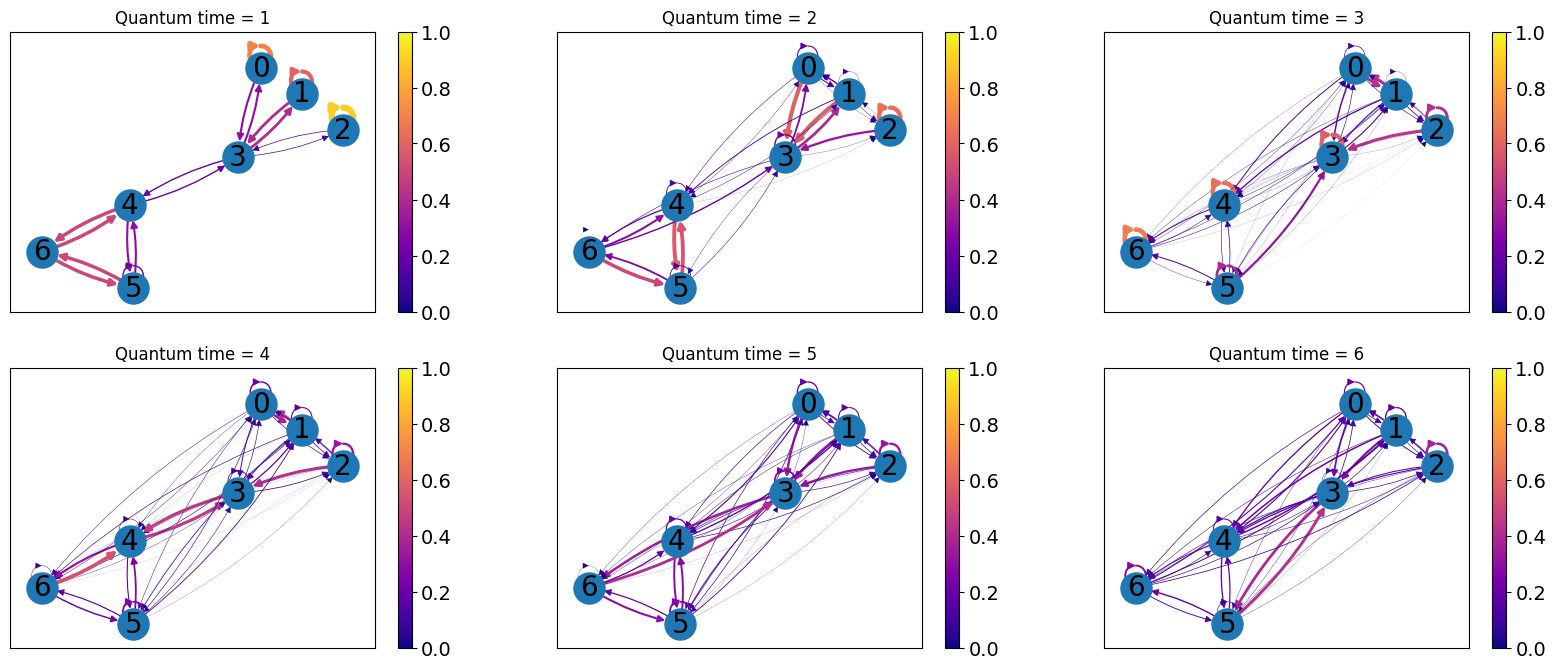

In [10]:
# Represent the first six semiclassical walks. Quantum time = 1, 2, 3, 4, 5, 6.
final_quantum_time = 6

plt.figure(figsize=(20,8))

for time in range(1,final_quantum_time+1):
    
    # Obtain the semiclassical matrix for the desired quantum time.
    semiclassical_matrix = semiclassical_matrices[time]
    
    # Create a graph using NetworkX.
    graph = nx.from_numpy_array(semiclassical_matrix.T,create_using=nx.DiGraph)
    graph_false = nx.from_numpy_array(semiclassical_matrix.T)
    
    plt.subplot(2,3,time)
    # Code for plotting the graph.
    nodes = nx.draw_networkx_nodes(graph_false,pos=pos,node_color=[0 for a in graph.nodes()],cmap=cmap,vmin=0,vmax=1,node_size=0.1)
    cbar = plt.colorbar(nodes)
    cbar.ax.tick_params(labelsize=14)
    nx.draw_networkx(graph, with_labels=True, pos=pos, width=weights_gr(graph)*5, edge_color=weights_gr(graph),edge_cmap=cmap,connectionstyle='arc3, rad = 0.1',edge_vmin=0,edge_vmax=1,node_size=500,font_size=20)
    plt.title('Quantum time = '+str(time))

plt.show()

The semiclassical walk of class $I$ for a quantum time = 1 corresponds to the classical walk. However, for a larger value of the quantum time we obtain geuine walks. Moreover, the semiclassical transition matrices are no longer symmetric.

<a name='3'></a>
## 3 - Semiclassical Walk Simulation

A semiclassical walk is like a classical walk, but the transition matrix encodes a quantum evolution. Thus, given a semiclassical transition matrix for a particular quantum time, we can simulate the semiclassical walk using our classical walk simulator.

In this example, we simulate the semiclassical walk at $t_q = 3$.

In [11]:
quantum_time = 3

# Obtain the semiclassical transition matrix.
G_semiclassical = semiclassical_matrices[quantum_time]

# Create an initial probability distribution of the walker.
initial_distribution = np.ones(N)/N

# Use the classical simulator to perform the semiclassical walk for 20 steps.
"""Args:
    transition_matrix: Column-stochastic transition matrix.
    time_steps: Number of steps of the classical walk.
    initial_distribution: Initial probability distribution of the walker. Default: the uniform one.
"""
probability_distributions = sw.classical_walk_simulator(transition_matrix=G_semiclassical,time_steps=20,initial_distribution=initial_distribution)

# We can do without the parameter initial_distribution if we are using the uniform distribution.
probability_distributions = sw.classical_walk_simulator(G_semiclassical,20)

We can plot the probabilities of each node at each time step, observing that they converge. The last distribution corresponds to the limiting distribution of the particular semiclassical walk.

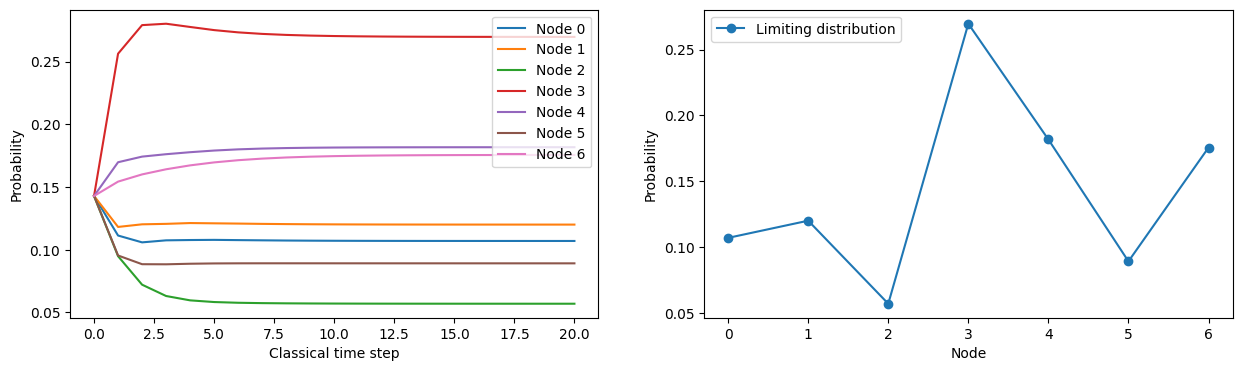

In [12]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(probability_distributions)
plt.legend([f'Node {n}' for n in range(N)],loc=1)
plt.xlabel('Classical time step')
plt.ylabel('Probability')

plt.subplot(1,2,2)
plt.plot(probability_distributions[-1],'-o')
plt.legend(['Limiting distribution'],loc=2)
plt.xlabel('Node')
plt.ylabel('Probability')

plt.show()

<a name='4'></a>
## 4 - Conclusions

We have seen how to use our semiclassical walk simulator to obtain the semiclassical matrices from a classical transition matrix. Moreover, we have represented the semiclassical walks as graphs using NetworkX, and we have performed a particular semiclassical walk over an initial probability distribution of the walker.

<a name='5'></a>
## 5 - References

- [1] **[S. A. Ortega and M. A. Martin-Delgado. SQUWALS: A Szegedy QUantum WALks Simulator. Advanced Quantum Technologies, 7:2400022, 2024.](https://advanced.onlinelibrary.wiley.com/doi/full/10.1002/qute.202400022)**
- [2] **[S. A. Ortega and M. A. Martin-Delgado. Discrete-Time Semiclassical Szegedy Quantum Walks. Physica A, 625:129021, 2023.](https://www.sciencedirect.com/science/article/pii/S0378437123005769)**